# Change tensorflow version from 2.6.4 to 2.9.1

I noticed that the default version of tensorflow (2.6.4) has a problem of printing unecessary clean up messages. for this reason I upgraded to tensorflow 2.9.1

In [ ]:
!pip uninstall tensorflow --yes
!pip install tensorflow_decision_forests
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 --yes
!pip install kerassurgeon 

# Library
here are the required packages/modules we will use to perform the tasks

In [ ]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import glob
import pathlib
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import datasets, layers, models,Input,Model 
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import  Bidirectional, Conv2D, BatchNormalization, MaxPooling2D, Flatten, LSTM, Dense, Lambda, Dropout,Reshape
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from tensorflow.keras.metrics import Accuracy, Recall,Precision
from sklearn.tree import DecisionTreeClassifier as Decisiontree
from sklearn.svm import SVC as Supportvectorclassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time
from functools import reduce
from kerassurgeon.operations import delete_layer, insert_layer
from keras.utils import to_categorical

Just checking if tensorflow was sucessfully upgraded.

In [ ]:
print(tf.__version__)

# Introduction
This study utilized a secondary radiography dataset, retrieved from the Kaggle data repository. The original copy was compiled from publicly available posterior-to-anterior (AP) chest x-rays by a group of research collaborators from Qatar and Bangladesh. The experimental setting involved a placebo type of design with 3 study groups; these include A control group with 423 x-ray images from normal people, an experimental group with 1579 x-ray images from COVID infected persons, and a group with viral pneumonia infected persons with 1485 images (Chowdhury et al., 2020). The data will be split into a training set with 75% and a testing set with 25%, during the preprocessing step. The testing set will be held to help evaluate the performance of the models on new data.

# Loading the data

Here I will load the image data.I will use the tensorlow `image_from_directory()`  which I consider efficient in loading image data.  Images will be loaded in their original form of `299x 299` shape.

We have a total of **13808** images in consideration, **10192** are from normal cases while **3616** are from covid infected cases. The overall data was randomly split into **80%(11047)** training images and **20%(2761)** testing images.

About **8163** of the training images are from normal people while the rest are from covid patients. For testing **2029** are from normal people while the rest are covid infected cases. 

The data is saved as  batched tensorflow images with batch sizes of 32 images.There is a total of 346 batches on the training set and 87 images on the training.

Data link:https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

In [ ]:
# some parameter settings

batch_size=32
image_height=299
image_width=299
n=1000
epochs=100

here we are loading the images from the folder they are saved.Tensorflow pipeline will be used to allow flow of images from directory.

In [ ]:
# reading images from directory(folder)

data_dir= "../input/mycoviddata/covid images/binary"
train_ds= tf.keras.utils.image_dataset_from_directory(
  data_dir,
  color_mode='grayscale',
  labels='inferred',
  label_mode='categorical',
  subset="training",
  image_size=(image_height,image_width),
  validation_split=0.20,
  seed=100)

test_ds= tf.keras.utils.image_dataset_from_directory(
  data_dir,
  color_mode='grayscale',
  labels='inferred',
  label_mode='categorical',
  subset="validation",
  image_size=(299, 299),
  validation_split=0.20,
  seed=100)

Your images belong to these two directories. COVID and Normal

In [ ]:
# Class names
train_ds.class_names

Here we collected details of the image, such as image counts in each group, training size and testing size etc. they are the details graphed below.

In [ ]:
# preparing summary counts
data_dir=pathlib.Path('../input/mycoviddata/covid images/binary')

# function to get labs 
def fetch_labels(filepath):
    return str(filepath).split('/')[-2]

# Training labels
labs=list(map(fetch_labels,train_ds.file_paths))
trainlabs=pd.DataFrame(labs,columns=["Labels"])

# testing labels
labs=list(map(fetch_labels,test_ds.file_paths))
testlabs=pd.DataFrame(labs,columns=["Labels"])

# Overall image count
df=pd.DataFrame([["Normal",len(list(data_dir.glob('Normal/*.png')))],
              ["COVID",len(list(data_dir.glob('COVID/*.png')))]]
             , columns=['Label','count'])
# batch count
df1=pd.DataFrame([["Training",len(train_ds)],
              ["Testing",len(test_ds)]]
             , columns=['Label','count'])

In [ ]:
print("-------------- Overall data ------------------------------------\n")
print("image count:",len(list(data_dir.glob('*/*.png'))))
print("Normal image count:",len(list(data_dir.glob('Normal/*.png'))))
print("Covid image count:",len(list(data_dir.glob('COVID/*.png'))))

print("\n------------Train test split--------------------------------\n")
print("Training count:",len(trainlabs))
print("Testing count:",len(testlabs))
print("Number of batches training set:",len(train_ds))
print("Number of batches testing set:",len(test_ds)) 

In [ ]:
figure,ax=plt.subplots(nrows=2,ncols=2,figsize=(12,10))
sns.barplot(x = 'Label',y = 'count',data = df,ax=ax[0,0])
sns.countplot(x='Labels',data=trainlabs,ax=ax[0,1])
sns.countplot(x='Labels',data=testlabs,ax=ax[1,0])
sns.barplot(x = 'Label',y = 'count',data = df1,ax=ax[1,1])
ax[0,0].set_title('Total Images')
ax[0,1].set_title('Training images')
ax[1,0].set_title('Testing images')
ax[1,1].set_title('Batch counts')
for p, label in zip(ax[0,1].patches, trainlabs['Labels'].value_counts().index):
    ax[0,1].annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+20))
for p, label in zip(ax[1,0].patches, testlabs['Labels'].value_counts().index):
    ax[1,0].annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+20))
for p, label in zip(ax[0,0].patches, df['count'].index):
    ax[0,0].annotate(round(p.get_height()), (p.get_x()+0.25, p.get_height()+20))
for p, label in zip(ax[1,1].patches, df1['count'].index):
    ax[1,1].annotate(round(p.get_height()), (p.get_x()+0.25, p.get_height()+5))
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[1,0].set_xlabel("")
ax[1,1].set_xlabel("")
    
plt.savefig('original data1.png')


# Visualizing a sample of the images

Below I visualized a sample of 16 images,to see if the labels are matched properly.

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ls=labels[i].numpy()
        x=[j for j, y in enumerate(ls) if y == 1]
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"),cmap='Greys_r')
        plt.title(train_ds.class_names[x[0]])
        plt.axis("off")
        
plt.savefig('original data2.png')

Here are tensorflow commands to allow prefetching and caching. This has to do with tensorflow, when using tensorflow caching means, the data will cached after first epoch. so will not be loaded afresh everytime. prefetching means processing is overlapped(sort of multi-tasking)

In [ ]:
# performance configuration
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Modelling 

 Over the recent past, Convolution Neural Networks (CNN or Convnet) has gained popularity in visual imagery and video processing (Wu et al., 2017). This is due to its architecture which allows zooming into images to get pixel information and pooling ability. Artificial Neural network (ANN) on the other hand uses weighting and activation functions to perform regression/classification tasks. This study will make use of sequential layers of CNN to perform feature extraction and classification. The study architecture is inspired by a VGG16 architecture and will involve a **feature extraction layers** and **classification layers**. The feature extraction part includes sequences of convolution and pooling layer. Conversely, the classification part includes two layers of feed-forward artificial neural networks (ANN), tasked with classifying images based on features extracted during feature extraction.  The model will be implemented using Keras.

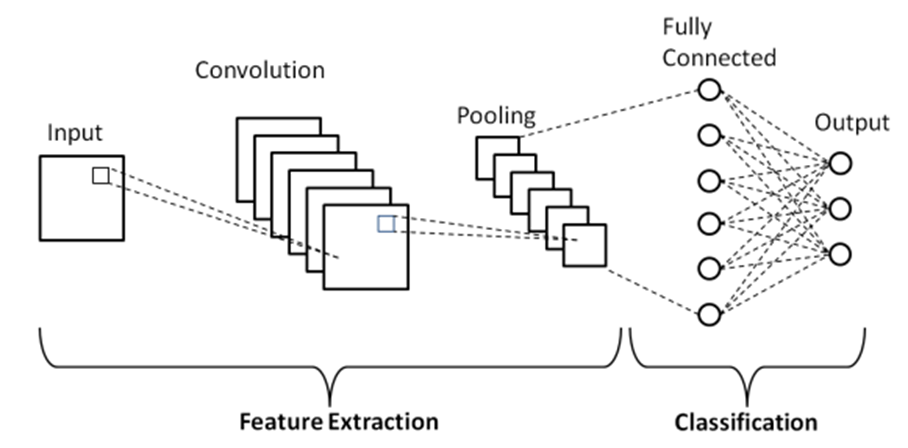


Here is our model, This section is the feature extraction part, each block  contains convolution layers normalization layers and maximum pooling layers.

In [ ]:
model=Sequential(name="Full_Model")
# Block 1
model.add(Input(shape=(image_height,image_width,1),name="input"))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu',name="block1_conv_1"))
model.add(BatchNormalization(name="block1_batch_normalization1"))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu',name="block1_conv_2"))
model.add(BatchNormalization(name="block1_batch_normalization2"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),name="block1_maxpool"))

# Block 2

model.add(Conv2D(128, (3, 3), padding='same', activation='relu',name="block2_conv_1"))
model.add(BatchNormalization(name="block2_batch_normalization1"))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu',name="block2_conv_2"))
model.add(BatchNormalization(name="block2_batch_normalization2"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),name="block2_maxpool"))
          
# Block 3
model.add(Conv2D(256, (3, 3), padding='same', activation='relu',name="block3_conv_1"))
model.add(BatchNormalization(name="block3_batch_normalization1"))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu',name="block3_conv_2"))
model.add(BatchNormalization(name="block3_batch_normalization2"))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu',name="block3_conv_3"))
model.add(BatchNormalization(name="block3_batch_normalization3"))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),name="block3_maxpool"))

# Block 4
model.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block4_conv_1"))
model.add(BatchNormalization(name="block4_batch_normalization1"))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block4_conv_2"))
model.add(BatchNormalization(name="block4_batch_normalization2"))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block4_conv_3"))
model.add(BatchNormalization(name="block4_batch_normalization3"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),name="block4_maxpool"))

# fifth convolution layer

model.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block5_conv_1"))
model.add(BatchNormalization(name="block5_batch_normalization1"))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block5_conv_2"))
model.add(BatchNormalization(name="block5_batch_normalization2"))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block5_conv_3"))
model.add(BatchNormalization(name="block5_batch_normalization3"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),name="block5_maxpool"))
#  flatten
model.add(Flatten(name="flatten_layer"))

## Adding dense layers

Here we will connect the feature extraction part with the ANN classifier to produce a single model like shown on the figure above.

In [ ]:
# Dense connected layers
model.add(Dense(units=64,activation="relu"))
model.add(Dense(units=64,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

In [ ]:
#model.summary()

# Compile and fit the ANN model. 

A sparse categoricalCrossentropy will be used.

In [ ]:
model.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=["accuracy",
           tf.keras.metrics.Recall(name="Sensitivity",class_id=0),
           tf.keras.metrics.Recall(name="Specificity",class_id=1),
           tf.keras.metrics.Precision(name="Precision",class_id=0),
          tfa.metrics.F1Score(num_classes=2, average="micro")])

To make the code we will use the first 20 Batches. But later we will run the code with the full data

In [ ]:
train_ds=train_ds.take(n)

# fitting the model

In [ ]:
hist=model.fit(
 train_ds,
  validation_data=test_ds,
 epochs=epochs) 

Graphing accuracy on training vs testing set.

In [ ]:
#Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# loss
ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.savefig('original data3.png')

# Here is the model perfomance metric.

In [ ]:
#m1=model.evaluate(test_ds)
st = time.time()
m1=model.evaluate(test_ds)[1:6]
et = time.time()
elapsed_time=round((et - st)/len(testlabs),4)
print('Execution time:', elapsed_time, 'seconds')
m1.append(elapsed_time)
mod1=pd.DataFrame({"Measure":['Accuracy','Sensitivity','Specificty','Precision',"F1-score","Excecution time"],
    "Original Dataset":[np.round(float(i), 4) for i in m1]})
mod1

# save model and data

In [ ]:
model.save("my_model")
train_ds.save("train_ds")
test_ds.save("test_ds")
#model = keras.models.load_model('my_model')
#train_ds=tf.data.Dataset.load("train_ds")
#test_ds=tf.data.Dataset.load("test_ds")

# With Benchmark datasets

Here the approach will be tested with other real life datasets of varied size and difficult. This way we are stressing the model to see how it performs on different situations.

## Dataset 1: Corona hack

Just like the study dataset this benchmark data consists of x-ray images from several study groups. The control group includes x-ray scans from **normal persons (1576)**, and the experimental group has **58 x-ray scans from COVID -19 infected persons**. The other group contains **ARDS, SARS, and streptococcus bacteria**. The choice of the data was motivated by the presence of competing outcomes (it consists of x-ray images for other respiratory infections, which are more like COVID-19 and pneumonia infections). With this type of data, the ability of the algorithms to detect and identify COVID-19 in presence of other chest infections can be investigated. 

Datalink: https://www.kaggle.com/datasets/praveengovi/coronahack-chest-xraydataset

In total the data consists of **5910 images**, and which are split into **5273 training images** and **637 testing images**. there are 5 classes of intrest including: *Covid(58 images),ARDS(2 images),Normal(1576),Other viral infections(1497 images) bacteria(2777 images)* The testing set has 165 batches while testing has 20 batches.

In [ ]:
data_dir1= "../input/coronahack/data/train"  
train_ds1= tf.keras.utils.image_dataset_from_directory(
  data_dir1,
  color_mode='grayscale',
  labels='inferred',
  label_mode='categorical',
  image_size=(image_height,image_width),
  validation_split=0,
  seed=100)
data_dir2= "../input/coronahack/data/test"

test_ds1= tf.keras.utils.image_dataset_from_directory(
  data_dir2,
  color_mode='grayscale',
  labels='inferred',
  label_mode='categorical',
  image_size=(299, 299),
  validation_split=0,
  seed=100)
 

The images belong to these 5 classes

In [ ]:
 # Class names
train_ds1.class_names

Here we collected details of the image, such as image counts in each group, training size and testing size etc. they are the details graphed below.

In [ ]:
# Training labels
labs=list(map(fetch_labels,train_ds1.file_paths))
trainlabs=pd.DataFrame(labs,columns=["Labels"])

# testing labels
labs=list(map(fetch_labels,test_ds1.file_paths))
testlabs=pd.DataFrame(labs,columns=["Labels"])

# Overall image count
data_dirall=pathlib.Path("../input/coronahack/data")

df=pd.DataFrame([["ARDS",len(list(data_dirall.glob('*/ARDS/*.*')))],
              ["COVID-19",len(list(data_dirall.glob('*/COVID-19/*.*')))],
                ["Normal",len(list(data_dirall.glob('*/Normal/*.*')))],
                ["Other_viral_infections",len(list(data_dirall.glob('*/Other_viral_infections/*.*')))],
                ["bacteria",len(list(data_dirall.glob('*/bacteria/*.png')))]]
             , columns=['Label','count'])

# batch count
df1=pd.DataFrame([["Training",len(train_ds1)],
              ["Testing",len(test_ds1)]]
             , columns=['Label','count'])

In [ ]:
print("-------------- Overall data ------------------------------------\n")
print("image count:",len(list(data_dirall.glob('*/*/*.*'))))
print("ARDS image count:",len(list(data_dirall.glob('*/ARDS/*.*'))))
print("Covid image count:",len(list(data_dirall.glob('*/COVID-19/*.*'))))
print("Normal count:",len(list(data_dirall.glob('*/Normal/*.*'))))
print("Other_viral_infections count:",len(list(data_dirall.glob('*/Other_viral_infections/*.*'))))
print("bacteria image count:",len(list(data_dirall.glob('*/bacteria/*.*'))))

print("\n------------Train test split--------------------------------\n")

print("Training count:",len(trainlabs))
print("Testing count:",len(testlabs))
print("Number of batches training set:",len(train_ds1))
print("Number of batches testing set:",len(test_ds1)) 

Visualizing a the above summary statistics

In [ ]:
figure,ax=plt.subplots(nrows=2,ncols=2,figsize=(12,12))
sns.barplot(x = 'Label',y = 'count',data = df,ax=ax[0,0])
sns.countplot(x='Labels',data=trainlabs,ax=ax[0,1])
sns.countplot(x='Labels',data=testlabs,ax=ax[1,0])
sns.barplot(x = 'Label',y = 'count',data = df1,ax=ax[1,1])
ax[0,0].set_title('Total Images')
ax[0,1].set_title('Training images')
ax[1,0].set_title('Testing images')
ax[1,1].set_title('Batch counts')
for p, label in zip(ax[0,1].patches, trainlabs['Labels'].value_counts().index):
    ax[0,1].annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+20))
for p, label in zip(ax[1,0].patches, testlabs['Labels'].value_counts().index):
    ax[1,0].annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+5))
for p, label in zip(ax[0,0].patches, df['count'].index):
    ax[0,0].annotate(round(p.get_height()), (p.get_x()+0.25, p.get_height()+20))
for p, label in zip(ax[1,1].patches, df1['count'].index):
    ax[1,1].annotate(round(p.get_height()), (p.get_x()+0.25, p.get_height()+5))
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[1,0].set_xlabel("")
ax[1,1].set_xlabel("")
ax[0,0].tick_params(axis='x',rotation=90)
ax[0,1].tick_params(axis='x',rotation=90)
ax[1,0].tick_params(axis='x',rotation=90)
plt.tight_layout()
plt.savefig('coronahack data1.png')
                    

A snapshot of the images

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
    for i in range(16):
        ls=labels[i].numpy()
        x=[j for j, y in enumerate(ls) if y == 1]
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"),cmap='Greys_r')
        plt.title(train_ds1.class_names[x[0]])
        plt.axis("off")
        
plt.savefig('coronahack data2.png')

In [ ]:
# performance configuration

AUTOTUNE = tf.data.AUTOTUNE
train_ds1 = train_ds1.cache().prefetch(buffer_size=AUTOTUNE)
test_ds1 = test_ds1.cache().prefetch(buffer_size=AUTOTUNE)

taking a sample of first 20 batches.

In [ ]:
train_ds1=train_ds1.take(n)

Unlike the other data,the target class here is class 2. so we have to reconfigure the model.

In [ ]:
modela=Sequential(name="Full_Model")
# Block 1
modela.add(Input(shape=(image_height,image_width,1),name="input")) 
modela.add(Conv2D(64, (3, 3), padding='same', activation='relu',name="block1_conv_1"))
modela.add(BatchNormalization(name="block1_batch_normalization1"))
modela.add(Conv2D(64, (3, 3), padding='same', activation='relu',name="block1_conv_2"))
modela.add(BatchNormalization(name="block1_batch_normalization2"))
modela.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),name="block1_maxpool"))

# Block 2

modela.add(Conv2D(128, (3, 3), padding='same', activation='relu',name="block2_conv_1"))
modela.add(BatchNormalization(name="block2_batch_normalization1"))
modela.add(Conv2D(128, (3, 3), padding='same', activation='relu',name="block2_conv_2"))
modela.add(BatchNormalization(name="block2_batch_normalization2"))
modela.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),name="block2_maxpool"))
          
# Block 3
modela.add(Conv2D(256, (3, 3), padding='same', activation='relu',name="block3_conv_1"))
modela.add(BatchNormalization(name="block3_batch_normalization1"))
modela.add(Conv2D(256, (3, 3), padding='same', activation='relu',name="block3_conv_2"))
modela.add(BatchNormalization(name="block3_batch_normalization2"))
modela.add(Conv2D(256, (3, 3), padding='same', activation='relu',name="block3_conv_3"))
modela.add(BatchNormalization(name="block3_batch_normalization3"))
modela.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),name="block3_maxpool"))

# Block 4
modela.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block4_conv_1"))
modela.add(BatchNormalization(name="block4_batch_normalization1"))
modela.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block4_conv_2"))
modela.add(BatchNormalization(name="block4_batch_normalization2"))
modela.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block4_conv_3"))
modela.add(BatchNormalization(name="block4_batch_normalization3"))
modela.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),name="block4_maxpool"))

# fifth convolution layer

modela.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block5_conv_1"))
modela.add(BatchNormalization(name="block5_batch_normalization1"))
modela.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block5_conv_2"))
modela.add(BatchNormalization(name="block5_batch_normalization2"))
modela.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block5_conv_3"))
modela.add(BatchNormalization(name="block5_batch_normalization3"))
modela.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),name="block5_maxpool"))
#  flatten
modela.add(Flatten(name="flatten_layer"))

# Dense connected layers
modela.add(Dense(units=64,activation="relu"))
modela.add(Dense(units=64,activation="relu"))
modela.add(Dense(units=5, activation="softmax"))

In [ ]:
modela.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=["accuracy",
           tf.keras.metrics.Recall(name="Sensitivity",class_id=1),
           tf.keras.metrics.Recall(name="Specificity",class_id=2),
           tf.keras.metrics.Precision(name="Precision",class_id=1),
          tfa.metrics.F1Score(num_classes=5, average="micro")])

 fitting the model on this data.

In [ ]:
hist=modela.fit(
 train_ds1,
  validation_data=test_ds1,
 epochs=epochs)

Graphing accuracy

In [ ]:
# Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# loss
ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.savefig('coronahack data3.png')

In [ ]:

st = time.time()
m2=modela.evaluate(test_ds1)[1:6]
et = time.time()
elapsed_time=round((et - st)/len(testlabs),4)
print('Execution time:', elapsed_time, 'seconds')
m2.append(elapsed_time)
mod2=pd.DataFrame({"Measure":['Accuracy','Sensitivity','Specificty','Precision',"F1-score","Excecution time"],
    "Corona hack data":[np.round(float(i), 4) for i in m2]})
mod2


# Dataset 2: Chest X-Ray Scans (Pneumonia)

Over the past years, scores of research literature have shown respiratory infections to be common distress in both developing and developed countries (Keystone et al., 2013). The problem is more frequent in the upper respiratory tract. According to (Sails et al, 201). Respiratory infections contribute to nearly 20% of mortalities in infants (0-5years). COVID- 19 being a respiratory infection presents more problems, If not contained the disease has a high chance of inflating this percentage.  This dataset consists of Optical Coherence Tomography (OCT) and X-ray scans for normal and pneumonia cases in infants (0-5years). The motivation behind benchmarking the data here is to get a glimpse performance of the algorithms with infant data. 

Data: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


In total the data consists of **5856 images**, and which are split into **5216 training images** and **624 testing images** and **16 validation images**. there are 2 classes of intrest including:*Normal(1583) and pneumonia(4273 images)* The testing set has 163 batches while testing has 20 batches, the validation set has 1 batch. more breakdown can be found on the graphs

In [ ]:
data_dir1= "../input/chest-xray-pneumonia/chest_xray/train" 
train_ds1= tf.keras.utils.image_dataset_from_directory(
  data_dir1,
  color_mode='grayscale',
  labels='inferred',
   label_mode='categorical',
  image_size=(299,299),
  validation_split=0,
  seed=100)
data_dir2= "../input/chest-xray-pneumonia/chest_xray/test"

test_ds1= tf.keras.utils.image_dataset_from_directory(
  data_dir2,
  color_mode='grayscale',
  labels='inferred',
   label_mode='categorical',
  image_size=(299, 299),
  validation_split=0,
  seed=100)

data_dir3= "../input/chest-xray-pneumonia/chest_xray/val"
valid_ds1= tf.keras.utils.image_dataset_from_directory(
  data_dir3,
  color_mode='grayscale',
  labels='inferred',
   label_mode='categorical',
  image_size=(299, 299),
  validation_split=0,
  seed=100)


In [ ]:
# Training labels
labs=list(map(fetch_labels,train_ds1.file_paths))
trainlabs=pd.DataFrame(labs,columns=["Labels"])

# testing labels
labs=list(map(fetch_labels,test_ds1.file_paths))
testlabs=pd.DataFrame(labs,columns=["Labels"])

labs=list(map(fetch_labels,valid_ds1.file_paths))
validlabs=pd.DataFrame(labs,columns=["Labels"])

# Overall image count
data_dirall=pathlib.Path("../input/chest-xray-pneumonia/chest_xray/")
df=pd.DataFrame([["Normal",len(list(data_dirall.glob('*/NORMAL/*.*')))],
              ["Pneumonia",len(list(data_dirall.glob('*/PNEUMONIA/*.*')))]]
             , columns=['Label','count'])
# batch count
df1=pd.DataFrame([["Training",len(train_ds1)],
              ["Testing",len(test_ds1)],
                 ["Validation",len(valid_ds1)]],
                 columns=['Label','count'])

In [ ]:
print("-------------- Overall data ------------------------------------\n")
print("image count:",len(list(data_dirall.glob('*/NORMAL/*.*')))+len(list(data_dirall.glob('*/PNEUMONIA/*.*'))))
print("Normal image count:",len(list(data_dirall.glob('*/NORMAL/*.*'))))
print("Pneumonia image count:",len(list(data_dirall.glob('*/PNEUMONIA/*.*'))))

print("\n------------Train test split--------------------------------\n")
print("Training count:",len(trainlabs))
print("Testing count:",len(testlabs))
print("Validation count:",len(validlabs))
print("Number of batches training set:",len(train_ds1))
print("Number of batches testing set:",len(test_ds1)) 
print("Number of batches Validation set:",len(valid_ds1)) 

In [ ]:
figure,ax=plt.subplots(nrows=2,ncols=2,figsize=(12,10))
sns.barplot(x = 'Label',y = 'count',data = df,ax=ax[0,0])
sns.countplot(x='Labels',data=trainlabs,ax=ax[0,1])
sns.countplot(x='Labels',data=testlabs,ax=ax[1,0])
sns.barplot(x = 'Label',y = 'count',data = df1,ax=ax[1,1])
ax[0,0].set_title('Total Images')
ax[0,1].set_title('Training images')
ax[1,0].set_title('Testing images')
ax[1,1].set_title('Batch counts')
for p, label in zip(ax[0,1].patches, trainlabs['Labels'].value_counts().index):
    ax[0,1].annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+20))
for p, label in zip(ax[1,0].patches, testlabs['Labels'].value_counts().index):
    ax[1,0].annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+20))
for p, label in zip(ax[0,0].patches, df['count'].index):
    ax[0,0].annotate(round(p.get_height()), (p.get_x()+0.25, p.get_height()+20))
for p, label in zip(ax[1,1].patches, df1['count'].index):
    ax[1,1].annotate(round(p.get_height()), (p.get_x()+0.25, p.get_height()+5))
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[1,0].set_xlabel("")
ax[1,1].set_xlabel("")
plt.savefig('xray images data1.png')

A snapshot of images

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
    for i in range(16):
        ls=labels[i].numpy()
        x=[j for j, y in enumerate(ls) if y == 1]
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"),cmap='Greys_r')
        plt.title(train_ds1.class_names[x[0]])
        plt.axis("off")
plt.savefig('xray images data2.png')

In [ ]:
train_ds1.class_names 

In [ ]:
# performance configuration
AUTOTUNE = tf.data.AUTOTUNE
train_ds1 = train_ds1.cache().prefetch(buffer_size=AUTOTUNE)
test_ds1 = test_ds1.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds1 = valid_ds1.cache().prefetch(buffer_size=AUTOTUNE)

Take a sample of training batches

In [ ]:
train_ds1=train_ds1.take(n)

Compile model with new label class arragement i.e 1= target category,0 is the other category.

In [ ]:
model.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=["accuracy",
           tf.keras.metrics.Recall(name="Sensitivity",class_id=1),
           tf.keras.metrics.Recall(name="Specificity",class_id=0),
           tf.keras.metrics.Precision(name="Precision",class_id=1),
          tfa.metrics.F1Score(num_classes=2, average="micro")])

In [ ]:
hist=model.fit(
 train_ds1,
  validation_data=test_ds1,
 epochs=epochs)

In [ ]:
# Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# loss
ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.savefig('xray images data3.png')

In [ ]:
st = time.time()
m3=model.evaluate(test_ds1)[1:6]
et = time.time()
elapsed_time=round((et - st)/len(testlabs),4)
print('Execution time:', elapsed_time, 'seconds')
m3.append(elapsed_time)
mod3=pd.DataFrame({"Measure":['Accuracy','Sensitivity','Specificty','Precision',"F1-score","Excecution time"],
    "Chest X-Ray Scans":[np.round(float(i), 4) for i in m3]})
mod3

# Dataset 4: COVID19+PNEUMONIA+NORMAL Chest X-Ray Images
According to (Gavrilov et al, 2018), the training set utilized to develop ML models greatly affects the model accuracy. In environments where there are no sufficient outcome cases (where only a few of the sampled patients are infected), the algorithms learn more from normal people and have little information about outcome cases. The consequence of this is having a model which diagnoses the absence of COVID-19 more accurately than it does with presence (higher specificity but low sensitivity). This benchmark data consists of **5228 images**  from 3 study group, the three includes; a control group with **1802 X-ray images from normal people**, an experimental group with **1626 COVID-19 X-ray images**, and **1800 images from people with other Pneumonia infections (Shastri et al., 2022)**.Here we aim at running the model with such balanced groups to make to see the difference.

Data link: https://www.kaggle.com/datasets/sachinkumar413/covid-pneumonia-normal-chest-xray-images

The training set has 131 batches while testing has 33 batches more breakdown can be found on the graphs

In [ ]:
data_dir1= "../input/covid-pneumonia-normal-chest-xray-images"
train_ds1= tf.keras.utils.image_dataset_from_directory(
  data_dir1,
  color_mode='grayscale',
  labels='inferred',
  label_mode='categorical',
  subset="training",
  image_size=(image_height,image_width),
  validation_split=0.20,
  seed=100)

test_ds1= tf.keras.utils.image_dataset_from_directory(
  data_dir1,
  color_mode='grayscale',
  labels='inferred',
  label_mode='categorical',
  subset="validation",
  image_size=(299, 299),
  validation_split=0.20,
  seed=100)



#Loading without the third group

data_dir2= "../input/covidpneumonianormal"
train_ds2= tf.keras.utils.image_dataset_from_directory(
  data_dir2,
  color_mode='grayscale',
  labels='inferred',
  label_mode='categorical',
  subset="training",
  image_size=(image_height,image_width),
  validation_split=0.20,
  seed=100)

test_ds2= tf.keras.utils.image_dataset_from_directory(
  data_dir2,
  color_mode='grayscale',
  labels='inferred',
  label_mode='categorical',
  subset="validation",
  image_size=(299, 299),
  validation_split=0.20,
  seed=100)

In [ ]:
# Training labels
labs=list(map(fetch_labels,train_ds1.file_paths))
trainlabs=pd.DataFrame(labs,columns=["Labels"])

# testing labels
labs=list(map(fetch_labels,test_ds1.file_paths))
testlabs=pd.DataFrame(labs,columns=["Labels"])

# Overall image count
data_dirall=pathlib.Path("../input/covid-pneumonia-normal-chest-xray-images")
df=pd.DataFrame([["Normal",len(list(data_dirall.glob('NORMAL/*.*')))],
              ["Pneumonia",len(list(data_dirall.glob('PNEUMONIA/*.*')))],
                ["Covid",len(list(data_dirall.glob('COVID/*.*')))]]
             , columns=['Label','count'])
# batch count
df1=pd.DataFrame([["Training",len(train_ds1)],
              ["Testing",len(test_ds1)]]
             , columns=['Label','count'])

In [ ]:
print("-------------- Overall data ------------------------------------\n")
print("image count:",len(list(data_dirall.glob('*/*.*'))))
print("Normal image count:",len(list(data_dirall.glob('NORMAL/*.*'))))
print("Pneumonia image count:",len(list(data_dirall.glob('PNEUMONIA/*.*'))))
print("Covid image count:",len(list(data_dirall.glob('COVID/*.*'))))
print("\n------------Train test split--------------------------------\n")
print("Training count:",len(trainlabs))
print("Testing count:",len(testlabs))
print("Number of batches training set:",len(train_ds1))
print("Number of batches testing set:",len(test_ds1)) 

In [ ]:
figure,ax=plt.subplots(nrows=2,ncols=2,figsize=(12,10))
sns.barplot(x = 'Label',y = 'count',data = df,ax=ax[0,0])
sns.countplot(x='Labels',data=trainlabs,ax=ax[0,1])
sns.countplot(x='Labels',data=testlabs,ax=ax[1,0])
sns.barplot(x = 'Label',y = 'count',data = df1,ax=ax[1,1])
ax[0,0].set_title('Total Images')
ax[0,1].set_title('Training images')
ax[1,0].set_title('Testing images')
ax[1,1].set_title('Batch counts')
for p, label in zip(ax[0,1].patches, trainlabs['Labels'].value_counts().index):
    ax[0,1].annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+20))
for p, label in zip(ax[1,0].patches, testlabs['Labels'].value_counts().index):
    ax[1,0].annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+13))
for p, label in zip(ax[0,0].patches, df['count'].index):
    ax[0,0].annotate(round(p.get_height()), (p.get_x()+0.25, p.get_height()+20))
for p, label in zip(ax[1,1].patches, df1['count'].index):
    ax[1,1].annotate(round(p.get_height()), (p.get_x()+0.25, p.get_height()+5))
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[1,0].set_xlabel("")
ax[1,1].set_xlabel("")
    
plt.savefig('covid pneumonia Normal data1.png')

a snapshot of the data

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
    for i in range(16):
        ls=labels[i].numpy()
        x=[j for j, y in enumerate(ls) if y == 1]
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"),cmap='Greys_r')
        plt.title(train_ds1.class_names[x[0]])
        plt.axis("off")
plt.savefig('covid pneumonia Normal data2.png')

In [ ]:
train_ds2.class_names

In [ ]:
# performance configuration
AUTOTUNE = tf.data.AUTOTUNE
train_ds1 = train_ds2.cache().prefetch(buffer_size=AUTOTUNE)
test_ds1 = test_ds2.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds1=train_ds.take(n)

In [ ]:
model.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=["accuracy",
           tf.keras.metrics.Recall(name="Sensitivity",class_id=0),
           tf.keras.metrics.Recall(name="Specificity",class_id=1),
           tf.keras.metrics.Precision(name="Precision",class_id=0),
          tfa.metrics.F1Score(num_classes=3, average="micro")])

In [ ]:
hist=model.fit(
 train_ds1,
  validation_data=test_ds1,
 epochs=epochs)

graphing accuracies

In [ ]:
# Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# loss
ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.savefig('covid pneumonia Normal data3.png')

In [ ]:
st = time.time()
m5=model.evaluate(test_ds1)[1:6]
et = time.time()
elapsed_time=round((et - st)/len(testlabs),4)
print('Execution time:', elapsed_time, 'seconds')
m5.append(elapsed_time)
mod5=pd.DataFrame({"Measure":['Accuracy','Sensitivity','Specificty','Precision',"F1-score","Excecution time"],
    "COvid+Pneumonia+Normal data":[np.round(float(i), 4) for i in m5]})
mod5

 # Dataset 3: Patch Camelyon

In [ ]:
ds,info=tfds.load("PatchCamelyon", with_info=True,as_supervised = True)  

In [ ]:
print(info)

In [ ]:
train_data = ds['train'].batch(batch_size=32)
valid_data = ds['validation'].batch(batch_size=32)
test_data = ds['test'].batch(batch_size=32)
train_ds1=train_data.take(n)

In [ ]:
lebb=['No metastatic tissue','metastatic tissue']

def to_lab(x):
    return lebb[round(x)]

def to_lab1(batched):
    labs=np.array([])

    for batch in batched:
        images,labels=batch
        lb=np.array(list(map(to_lab,labels.numpy())))
        labs= np.append(labs,lb)
    return labs

In [ ]:
trainlabs=to_lab1(train_data)
testlabs=to_lab1(test_data)
validlabs=to_lab1(valid_data)

In [ ]:
fulld=pd.concat([pd.DataFrame({'Label': trainlabs}),
           pd.DataFrame({'Label': testlabs}),
           pd.DataFrame({'Label': validlabs})])

figure,ax=plt.subplots(nrows=2,ncols=3,figsize=(12,12))

sns.countplot(x = 'Label',data = pd.concat([pd.DataFrame({'Label': trainlabs}),
           pd.DataFrame({'Label': testlabs}),
           pd.DataFrame({'Label': validlabs})]),ax=ax[0,0])

sns.countplot(x = 'Label',data = pd.DataFrame({'Label': trainlabs}),ax=ax[0,1])
sns.countplot(x='Label',data=pd.DataFrame({'Label': testlabs}),ax=ax[0,2])
sns.countplot(x='Label',data=pd.DataFrame({'Label': validlabs}),ax=ax[1,0])
sns.barplot(x = 'Label',y = 'count',
            data = pd.DataFrame({'Label':['Training',
                                          'Testing',
                                          'Validation'],
                                 'count': [len(train_data),
                                           len(test_data),
                                           len(valid_data)]}),ax=ax[1,1])
ax[0,0].set_title('Total Images')
ax[0,1].set_title('Training images')
ax[0,2].set_title('Testing images')
ax[1,0].set_title('validation images')
ax[1,1].set_title('Batch counts')

for p, label in zip(ax[0,0].patches, fulld['Label'].value_counts().index):
    ax[0,0].annotate(round(p.get_height()), (p.get_x()+0.25, p.get_height()+5))
                    
for p, label in zip(ax[0,1].patches, pd.value_counts(trainlabs).index):
    ax[0,1].annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+20))
    
for p, label in zip(ax[0,2].patches, pd.value_counts(trainlabs).index):
    ax[0,2].annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+20))
    
for p, label in zip(ax[1,0].patches, pd.value_counts(testlabs).index):
    ax[1,0].annotate(round(p.get_height()), (p.get_x()+0.25, p.get_height()+20))
    
for p, label in zip(ax[1,1].patches, pd.DataFrame({'Label':['Training',
                                          'Testing',
                                          'Validation'],
                                 'count': [len(train_data),
                                           len(test_data),
                                           len(valid_data)]})['Label'].value_counts().index):
    ax[1,1].annotate(round(p.get_height()), (p.get_x()+0.25, p.get_height()+20))
    
                    
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")
ax[1,0].set_xlabel("")
ax[1,1].set_xlabel("")
plt.savefig('Patch camelyon data1.png')

In [ ]:
plt.figure(figsize=(13, 13))
for data in train_ds1.take(1):
    images, labels = data
    for i in range(16):
        ls=labels[i].numpy()
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"),cmap='Greys_r')
        plt.title(lebb[ls])
        plt.axis("off")
plt.savefig('Patch camelyon data2.png')
        

In [ ]:
def to_categorical_crossentr(image, label):
    return tf.image.rgb_to_grayscale(image),tf.one_hot(label, 2,dtype=tf.int64)

train_data = ds['train'].map(to_categorical_crossentr).batch(batch_size=32)
valid_data = ds['validation'].map(to_categorical_crossentr).batch(batch_size=32)
test_data = ds['test'].map(to_categorical_crossentr).batch(batch_size=32)

In [ ]:
# performance configuration
AUTOTUNE = tf.data.AUTOTUNE
train_ds1 = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_ds1 = test_data.cache().prefetch(buffer_size=AUTOTUNE)
test_ds1 = test_data.cache().prefetch(buffer_size=AUTOTUNE) 
train_ds1=train_ds1.take(n)

In [ ]:
model10=Sequential(name="Full_Model10")
# Block 1
model10.add(Input(shape=(96,96,1),name="input"))
model10.add(Conv2D(64, (3, 3), padding='same', activation='relu',name="block1_conv_1"))
model10.add(BatchNormalization(name="block1_batch_normalization1"))
model10.add(Conv2D(64, (3, 3), padding='same', activation='relu',name="block1_conv_2"))
model10.add(BatchNormalization(name="block1_batch_normalization2"))
model10.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),name="block1_maxpool"))

# Block 2

model10.add(Conv2D(128, (3, 3), padding='same', activation='relu',name="block2_conv_1"))
model10.add(BatchNormalization(name="block2_batch_normalization1"))
model10.add(Conv2D(128, (3, 3), padding='same', activation='relu',name="block2_conv_2"))
model10.add(BatchNormalization(name="block2_batch_normalization2"))
model10.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),name="block2_maxpool"))
          
# Block 3
model10.add(Conv2D(256, (3, 3), padding='same', activation='relu',name="block3_conv_1"))
model10.add(BatchNormalization(name="block3_batch_normalization1"))
model10.add(Conv2D(256, (3, 3), padding='same', activation='relu',name="block3_conv_2"))
model10.add(BatchNormalization(name="block3_batch_normalization2"))
model10.add(Conv2D(256, (3, 3), padding='same', activation='relu',name="block3_conv_3"))
model10.add(BatchNormalization(name="block3_batch_normalization3"))
model10.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),name="block3_maxpool"))


# Block 4
model10.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block4_conv_1"))
model10.add(BatchNormalization(name="block4_batch_normalization1"))
model10.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block4_conv_2"))
model10.add(BatchNormalization(name="block4_batch_normalization2"))
model10.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block4_conv_3"))
model10.add(BatchNormalization(name="block4_batch_normalization3"))
model10.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),name="block4_maxpool"))

# fifth convolution layer

model10.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block5_conv_1"))
model10.add(BatchNormalization(name="block5_batch_normalization1"))
model10.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block5_conv_2"))
model10.add(BatchNormalization(name="block5_batch_normalization2"))
model10.add(Conv2D(512, (3, 3), padding='same', activation='relu',name="block5_conv_3"))
model10.add(BatchNormalization(name="block5_batch_normalization3"))
model10.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),name="block5_maxpool"))
#  flatten
model10.add(Flatten(name="flatten_layer"))

# Dense connected layers
model10.add(Dense(units=64,activation="relu"))
model10.add(Dense(units=64,activation="relu"))
model10.add(Dense(units=2, activation="softmax"))

In [ ]:
model10.compile(
  optimizer='adam',
  loss="categorical_crossentropy",
  metrics=["accuracy",
           tf.keras.metrics.Recall(name="Sensitivity",class_id=0),
           tf.keras.metrics.Recall(name="Specificity",class_id=1),
           tf.keras.metrics.Precision(name="Precision",class_id=0),
          tfa.metrics.F1Score(num_classes=2, average="micro")])

In [ ]:
hist=model10.fit(
 train_ds1,
  validation_data=test_ds1,
 epochs=epochs)

In [ ]:
#Accuracy
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

# loss
ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='upper left')
plt.savefig('Patch camelyon data3.png')

In [ ]:
#m1=model.evaluate(test_ds)
st = time.time()
m1=model10.evaluate(test_ds1)[1:6]
et = time.time()
elapsed_time=round((et - st)/len(testlabs),4)
print('Execution time:', elapsed_time, 'seconds')
m1.append(elapsed_time)
mod4=pd.DataFrame({"Measure":['Accuracy','Sensitivity','Specificty','Precision',"F1-score","Excecution time"],
    "Patch camelyon data":[np.round(float(i), 4) for i in m1]})
mod4

# comparing perfomance of our approach on varied datasets

In [ ]:
alldatasets=[mod1,mod2,mod3,mod4,mod5]
reduce(lambda  left,right: pd.merge(left,right,on=['Measure'],
                                            how='left'),alldatasets)